In [1]:
import rr_pso
import training_rr_pso
import covid_rr_pso

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
np.random.seed(124)

In [3]:
def plot_fitness(fval, savepath=None):
    mf = np.median(fval, axis=1)
    mfb = np.quantile(fval, 0.10, axis=1)
    mft = np.quantile(fval, 0.90, axis=1)

    plt.plot(mf, color="C0")
    plt.hlines(0.15, 0, len(mf), alpha=0.5, linewidth=1)
    plt.fill_between(np.arange(len(mf)), mfb, mft, alpha=0.5, color="C0")
    #plt.ylim([np.min(mf)*0.9, np.max(mf)*1.1])
    
    if savepath is not None:
        plt.savefig(savepath+"fitevol", dpi=300)
    plt.show()

def plot_convergence(data, X, savepath=None):
    gbest = np.zeros(shape=(X.shape[0], X.shape[2]))
    err_gbest = np.zeros(X.shape[0])
    err_mean = np.zeros(X.shape[0])
    t = np.arange(len(data))
    
    for i in range(X.shape[0]):        
        errs = np.array([np.sqrt(np.sum((data - covid_rr_pso.verhulst(t, *x))**2) / np.sum(data**2)) for x in X[i]])
        errmin = np.min(errs)
        err_mean[i] = np.mean(errs)
        gbesti = X[i][np.where(errs==errmin)[0]]
        
        if i == 0:
            err_gbest[0] = errmin
            gbest[0] = gbesti   
        elif errmin < err_gbest[i-1]:
            err_gbest[i] = errmin
            gbest[i] = gbesti
        else:
            err_gbest[i] = err_gbest[i-1]
            gbest[i] = gbest[i-1]
    
    plt.plot(err_gbest, label="$E_{rel}\\; g_{best}$")
    plt.plot(err_mean, label="$\\langle E_{rel}\\rangle$")
    plt.ylim([0, 1.5])
    plt.grid(alpha=0.5, linewidth=1)
    plt.legend()
    
    if savepath is not None:
        plt.savefig(savepath+"convergence", dpi=300)
    plt.show()
    
def plot_dispersion(X, savepath=None):
    avpos = np.mean(X, axis=1)
    
    d = np.array([np.mean([np.sqrt(sum((X[j,i]-avpos[j])**2)) for i in range(X.shape[1])]) for j in range(X.shape[0])])
    
    d = 100 * d / d[0]
    
    plt.plot(d, color='C0')
    plt.ylim([-50, 500])
    plt.grid(alpha=0.5, linewidth=1)
    
    if savepath is not None:
        plt.savefig(savepath+"dispersionevol", dpi=300)
    plt.show()
    
def print_final_dispersion(X):
    avpos0 = np.mean(X[0,:,:], axis=0)
    d0 = np.mean([np.sqrt(sum((X[0,i]-avpos0)**2)) for i in range(X.shape[1])])
    avpos100 = np.mean(X[X.shape[0]-1,:,:], axis=0)
    d100 = np.mean([np.sqrt(sum((X[X.shape[0]-1,i]-avpos100)**2)) for i in range(X.shape[1])])
    print("Final dispersion: {:.1f}%".format(d100 / d0 * 100))

def plot_waves(data, x0, savepath=None):
    fig, axs = plt.subplots(1, 2, figsize=[15, 5])
    ax1, ax2 = axs[:]
    t = np.arange(len(data))

    ax1.plot(data, color="C0")
    ax1.plot(np.min(data) + covid_rr_pso.verhulst(t, *x0), color="C1")

    ax2.fill_between(t[:-1], np.diff(data), 0, alpha=0.5, color="C0")
    ax2.plot(np.diff(covid_rr_pso.verhulst(t, *x0)), color="C1")
    
    ax1.set_axisbelow(True)
    ax1.grid(alpha=0.5, linewidth=1)
    
    ax2.set_axisbelow(True)
    ax2.grid(alpha=0.5, linewidth=1)
    
    if savepath is not None:
        plt.savefig(savepath+"waves", dpi=300)
    plt.show()
    
def plot_prediction(data, x, tforward, savepath=None):
    fig, axs = plt.subplots(1, 2, figsize=[15, 5])
    ax1, ax2 = axs[:]
    t = np.arange(len(data)+tforward)

    pred_set = np.array([covid_rr_pso.verhulst(t, *xi) for xi in x])
    pred_set_dif = np.diff(pred_set, axis=1)

    ax1.plot(data, color="C0")
    ax1.plot(np.min(data) + np.median(pred_set, axis=0), color="C1")
    ax1.fill_between(t,
                     np.min(data)+np.quantile(pred_set, q=0.25, axis=0),
                     np.min(data)+np.quantile(pred_set, q=0.75, axis=0),
                     color="C1", alpha=0.5)

    ax2.fill_between(t[:len(data)-1], np.diff(data), 0, alpha=0.5, color="C0")
    ax2.plot(np.median(pred_set_dif, axis=0), color="C1")
    ax2.fill_between(t[:-1],
                     np.quantile(pred_set_dif, q=0.25, axis=0),
                     np.quantile(pred_set_dif, q=0.75, axis=0),
                     color="C1", alpha=0.4)

    ax1.set_axisbelow(True)
    ax1.grid(alpha=0.5, linewidth=1)

    ax2.set_axisbelow(True)
    ax2.grid(alpha=0.5, linewidth=1)
    
    if savepath is not None:
        plt.savefig(savepath+"prediction", dpi=300)
    plt.show()
    
def plot_parameters(x, savepath=None):
    fig, axs = plt.subplots(1, 3, figsize=[15, 5])
    ax1, ax2, ax3 = axs[:]
    
    q1, q2 = np.quantile(x[:, 1], q=[0.1, 0.9])
    pfil = [x[i, 1] for i in np.where((x[:, 1]-q1)*(q2-x[:, 1]) > 0)]
    ax1.violinplot(pfil,
                   showmeans=False,
                   showmedians=True)
    ax1.set_title('$P_0$')

    q1, q2 = np.quantile(x[:, 0], q=[0.1, 0.9])
    kfil = [x[i, 0] for i in np.where((x[:, 0]-q1)*(q2-x[:, 0]) > 0)]
    ax2.violinplot(kfil,
                   showmeans=False,
                   showmedians=True)
    ax2.set_title('$K$')

    q1, q2 = np.quantile(x[:, 2], q=[0.1, 0.9])
    rfil = [x[i, 2] for i in np.where((x[:, 2]-q1)*(q2-x[:, 2]) > 0)]
    ax3.violinplot(rfil,
                   showmeans=False,
                   showmedians=True)
    ax3.set_title('$r$')
    
    if savepath is not None:
        plt.savefig(savepath+"params", dpi=300)
    plt.show()

# OLA 1

In [4]:
data = np.array(pd.read_csv('covid_aragon_ola_1')['PCR'])
errevol, x, x0, X = covid_rr_pso.fit_covid_wave(data, max_iter=200, test_number=20, nparticles=100, tol=0.15)

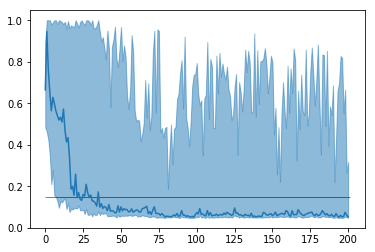

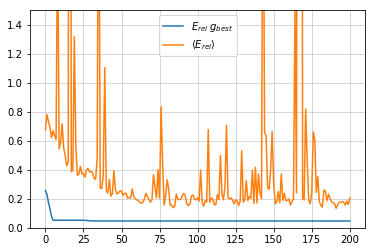

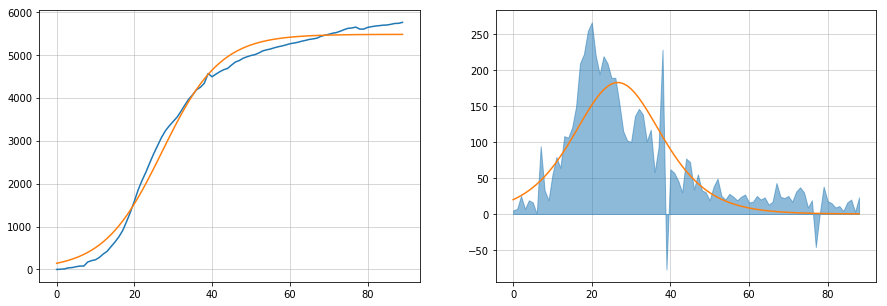

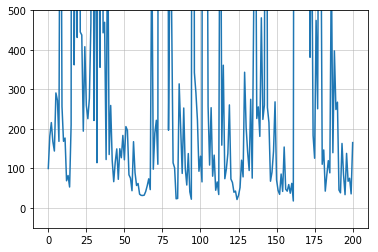

K=5476.98, P_0=143.44, r=0.13
d_min = 1.00
Final dispersion: 165.5%


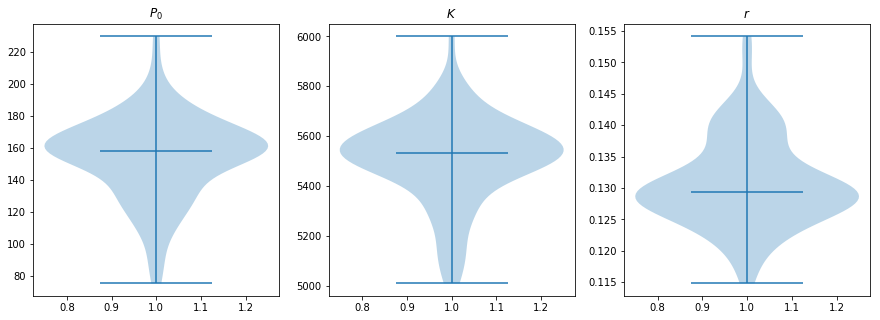

In [5]:
plot_fitness(errevol, "ola1")

plot_convergence(data, X)

plot_waves(data, x0, "ola1")

plot_dispersion(X, "ola1")

print("K={:.2f}, P_0={:.2f}, r={:.2f}".format(*x0))
print("d_min = {:.2f}".format(np.min(data)))

print_final_dispersion(X)

plot_parameters(x, "ola1")

# OLA 2

In [6]:
data = np.array(pd.read_csv('covid_aragon_ola_2')['PCR'])
errevol, x, x0, X= covid_rr_pso.fit_covid_wave(data, max_iter=200, test_number=20, nparticles=100, tol=0.15)

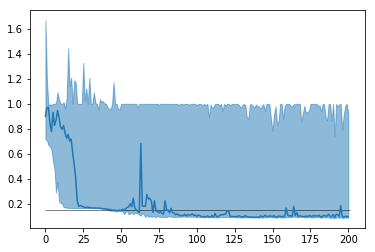

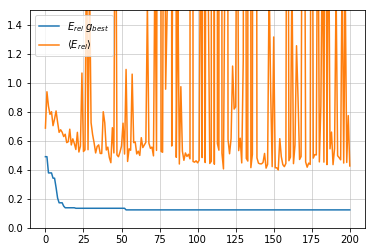

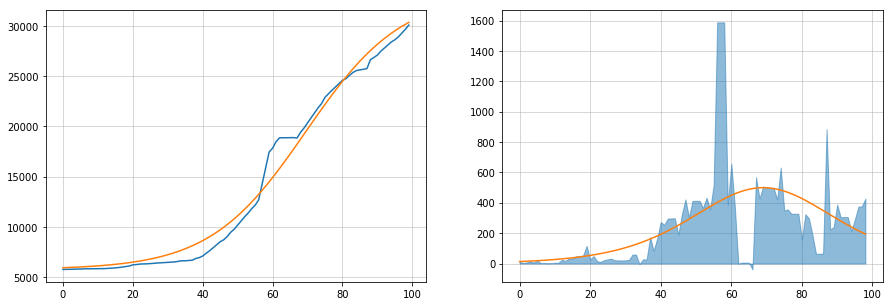

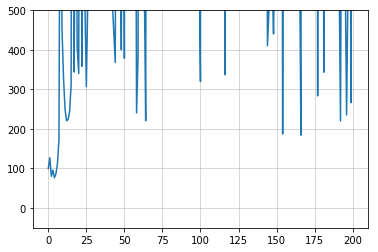

K=27477.69, P_0=173.78, r=0.07
d_min = 5770.00
Final dispersion: 2850.4%


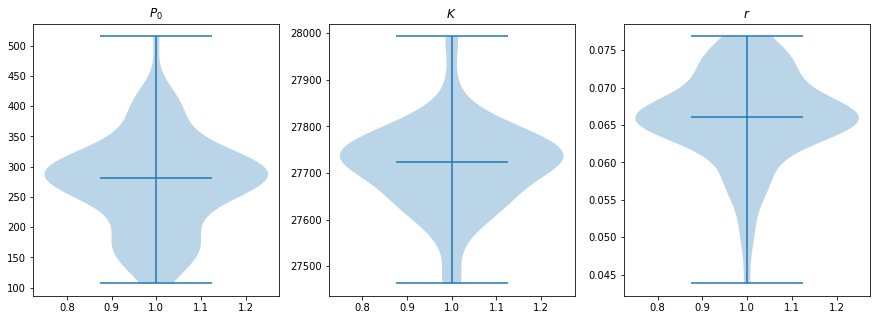

In [7]:
plot_fitness(errevol, "ola2")

plot_convergence(data, X)

plot_waves(data, x0, "ola2")

plot_dispersion(X, "ola2")

print("K={:.2f}, P_0={:.2f}, r={:.2f}".format(*x0))
print("d_min = {:.2f}".format(np.min(data)))

print_final_dispersion(X)

plot_parameters(x, "ola2")

# OLA 3

In [8]:
data = np.array(pd.read_csv('covid_aragon_ola_3')['PCR'])
errevol, x, x0, X = covid_rr_pso.fit_covid_wave(data, max_iter=200, test_number=20, nparticles=100, tol=0.15)

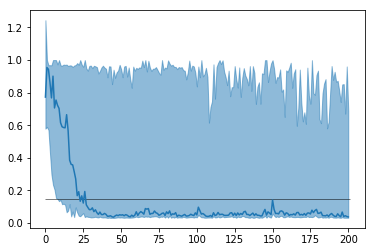

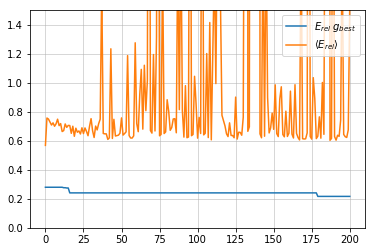

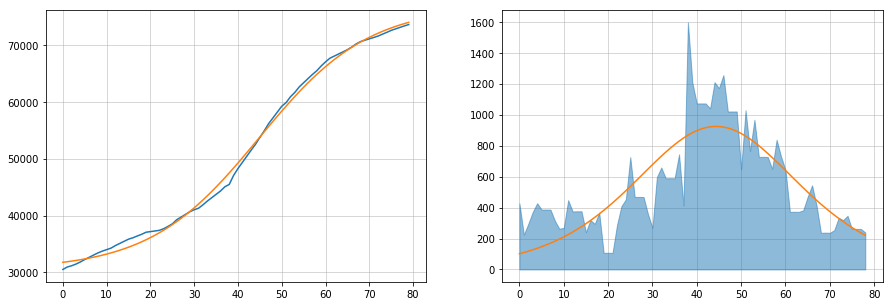

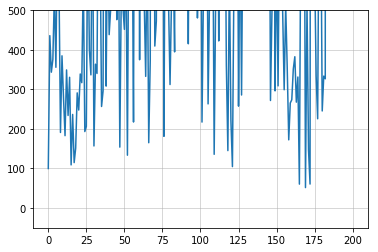

K=46326.24, P_0=1256.68, r=0.08
d_min = 30520.00
Final dispersion: 839.8%


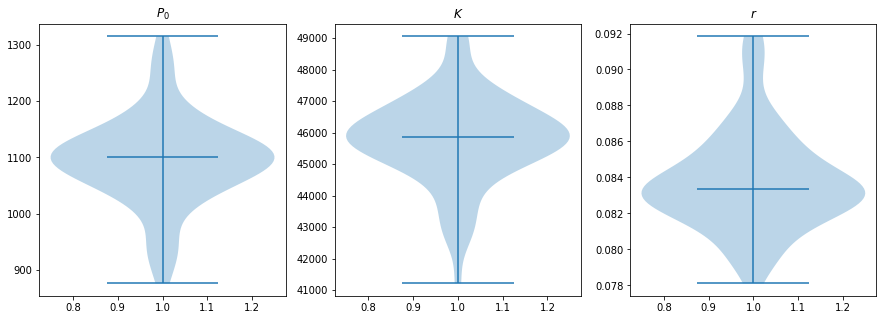

In [9]:
plot_fitness(errevol, "ola3")

plot_convergence(data, X)

plot_waves(data, x0, "ola3")

plot_dispersion(X, "ola3")

print("K={:.2f}, P_0={:.2f}, r={:.2f}".format(*x0))
print("d_min = {:.2f}".format(np.min(data)))

print_final_dispersion(X)

plot_parameters(x, "ola3")

# OLA 4

In [10]:
data = np.array(pd.read_csv('covid_aragon_ola_4')['PCR'])
errevol, x, x0, X = covid_rr_pso.fit_covid_wave(data, max_iter=200, test_number=20, nparticles=100, tol=0.15)

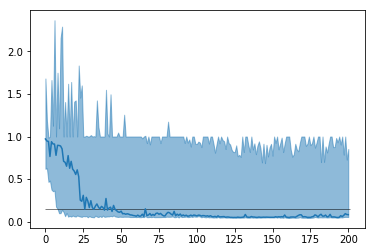

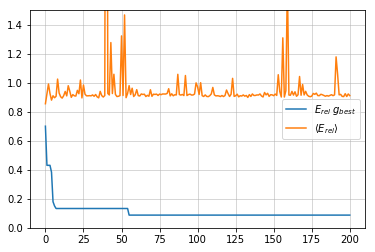

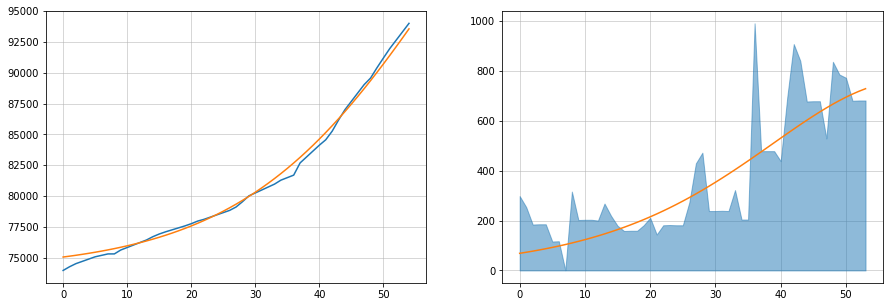

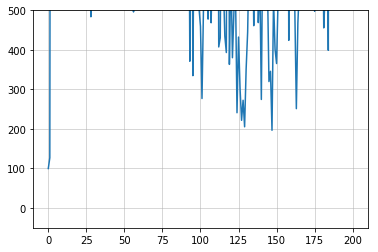

K=48651.11, P_0=1087.47, r=0.06
d_min = 73982.00
Final dispersion: 1032.2%


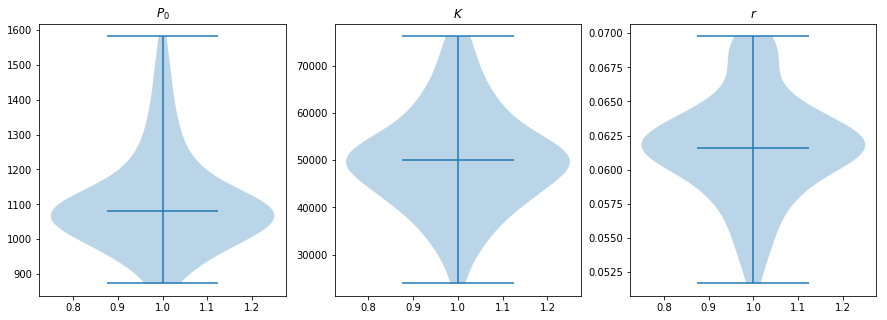

In [11]:
plot_fitness(errevol, "ola4")

plot_convergence(data, X)

plot_waves(data, x0, "ola4")

plot_dispersion(X, "ola4")

print("K={:.2f}, P_0={:.2f}, r={:.2f}".format(*x0))
print("d_min = {:.2f}".format(np.min(data)))

print_final_dispersion(X)

plot_parameters(x, "ola4")

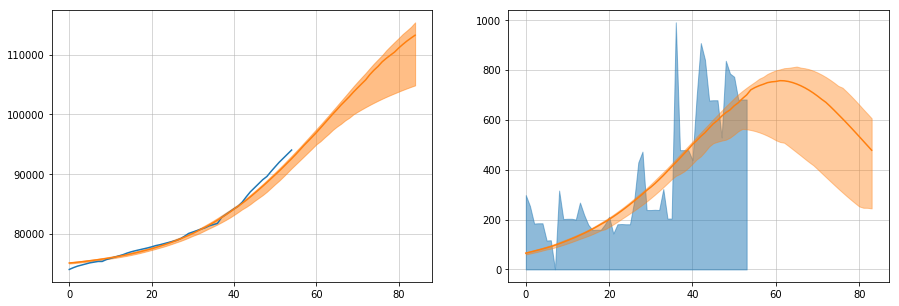

In [12]:
plot_prediction(data, x, 30, "ola4")